# Machine Learning for Inverse Power Flow: Voltage Estimation

Developed by Siobhan Powell, March 5, 2019.
    
This use case was developed for testing at SCE, but applies generally to any similar data set. 

Given the following: 

    - Load data at end points of the grid
    - Load data at an aggregation point of these end loads
    - Voltage measurements at the aggregation point 
    
#### Can we build a model for the voltage measurements at the aggregation point? 

The forward powerflow equations map voltage phase angle and magnitude to power injections in the network. The inverse mapping goes the other way, calculating the voltage from the power injections. We reduce this to calculate just the voltage magnitude from the loads in the network with good results, but in this use case with measurements only at the leaf nodes, will they be enough to build a good model? 

In [1]:
from forward_mlpf import ForwardMLPF
from inverse_mlpf import InverseMLPF
from make_pf_data import GenerateDataMLPF
import matplotlib.pyplot as plt
import numpy as np

## Load Data

Here you load the measurement data. You must have at least the real and reactive power injections at all buses, and the voltage magnitude at a bus that is an aggregation point of these loads. These are in three numpy matrices.

In each of these matrices, make sure that the rows represent the different time stamps and the columns represent the different buses. The aggregation point bus where you want to make the prediction should be bus 0; the first column. The matrices should then be num_samples (the number of time stamps) by num_bus (the number of buses in the data set). 

In this notebook fake data is created - **You should change the next box to load your real data.**

If you do not have voltage magnitude data for buses other than the aggregation point, pad the v matrix with zeros. 

In [2]:
# num_samples = 24*365 # Number of time stamps in the dataset
# num_bus = 14 # Number of buses in the dataset
# v = np.random.normal(loc=1.0, scale=0.025, size=(num_samples, num_bus)) # Voltage magnitude
# p = np.random.normal(loc=1.0, scale=1.0, size=(num_samples, num_bus)) # Real power injections / loads
# q = np.random.normal(loc=1.0, scale=1.0, size=(num_samples, num_bus)) # Reactive power injections / loads

In [2]:
v = np.load('/Users/spowell2/Documents/VADER-Data/rural1/v.npy') 
a = np.load('/Users/spowell2/Documents/VADER-Data/rural1/a.npy') 
p = np.load('/Users/spowell2/Documents/VADER-Data/rural1/p.npy')
q = np.load('/Users/spowell2/Documents/VADER-Data/rural1/q.npy') 
print(np.shape(v))
num_samples, num_bus = np.shape(v)

(8640, 26)


**Note with random data we don't expect to be able to predict anything**

# Initialize the Model and Process the Data

In [3]:
model = InverseMLPF(num_bus, num_samples)
model.supply_full_data(p, q, v, num_bus, num_samples)
model.train_test_split_data(rand_percent=True)

/Users/spowell2/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Train and Test a Linear Regression Model

This representation of the mapping with a simple Linear Regression. This is a very fast way to train and implement the model, and in some networks has been found to quite accurate. 

We set which_buses=[0] so that the estimation is only for the first bus (the aggregation point). This is an optional input. The default value tests the models for all of the buses in the dataset. 

In [4]:
model.fit_lr()
model.test_error_lr(which_buses=np.arange(0,num_bus)) # Set which_buses = [0] to just estimate the first bus
print('The RMSE for estimating the aggregation bus voltage with an LR model: ', model.total_rmse_lr)

The RMSE for estimating the aggregation bus voltage with an LR model:  2.67007400978679e-06


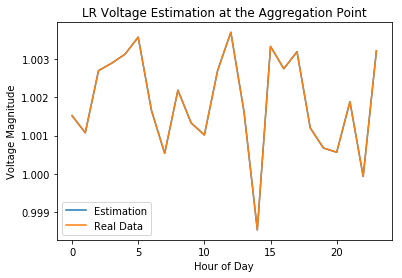

In [5]:
time_set = np.arange(0,24) # Look at the first day of the test set
which_bus_to_show = 2
plt.figure()
plt.plot(time_set,model.test_y_values_lr[time_set,which_bus_to_show],time_set,model.y_test[time_set,which_bus_to_show])
plt.xlabel('Hour of Day')
plt.ylabel('Voltage Magnitude')
plt.title('LR Voltage Estimation at the Aggregation Point')
plt.legend(labels=['Estimation','Real Data'])
plt.show()
# The corresponding error between the two is in model.test_error_values_lr[time_set]

# Train and Test a Support Vector Regression Model

This representation of the mapping with a Support Vector Regression uses a quadratic kernel, as studied in the paper referenced in README.md. This is slower to train and implement than the Linear Regression model, but in some networks has been found to be more accurate. 

We set which_buses=[0] so that the estimation is only for the first bus (the aggregation point). This is an optional input. The default value tests the models for all of the buses in the dataset. 

Increasing the options for C and eps by adding to the lists of values in C_set and eps_set is a way to improve the result. Note that the ConvergenceWarnings are a result of setting a cap on the number of iterations in the fitting, max_iter, not because we aren't using StandardScaler. Increasing the value of max_iter will let it come closer to convergence but will slow down training. 

In [6]:
model.scale_data()

In [20]:
bus_try = 2

In [21]:
C_set = [0.05, 0.1, 0.5, 1.0]  # Good values are often in the range of [0.1,10]
eps_set = [0.1, 0.5, 1.0]  # Good values are often in the range of [1e-7, 1e-1]
max_iter = 1e4  # Good values are usually in the range of 1e4, 1e5

model.fit_svr(C_set, eps_set, max_iter, which_bus=[bus_try])
model.test_error_svr(which_buses=[bus_try])


Done training voltage model for bus  2 , with a total of  2614  support vectors.


In [22]:
print(model.eps_best[bus_try]) # 0.5 for bus 1
print(model.C_best[bus_try]) # 0.5 for bus 1

[0.5]
[0.5]


In [10]:
np.shape(model.test_y_values_svr)

(1728, 1)

In [23]:
rmse = np.sqrt(np.mean(np.power(model.test_y_values_svr[:, 0] - model.y_test[:, bus_try], 2)))
print('The RMSE for estimating the aggregation bus voltage with an SVR model: ', rmse)#model.total_rmse_svr)

The RMSE for estimating the aggregation bus voltage with an SVR model:  0.5819141339457236


In [14]:
# model.test_error_svr(which_buses=np.arange(0,num_bus))

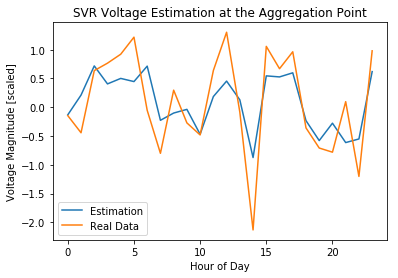

In [24]:
time_set = np.arange(0,24) # Look at the first day of the test set
which_bus_to_show = bus_try
plt.figure()
plt.plot(time_set,model.test_y_values_svr[time_set, 0], time_set,model.y_test[time_set,which_bus_to_show])
plt.xlabel('Hour of Day')
plt.ylabel('Voltage Magnitude [scaled]')
plt.title('SVR Voltage Estimation at the Aggregation Point')
plt.legend(labels=['Estimation','Real Data'])
plt.show()
# The corresponding error between the two is in model.test_error_values_svr[time_set]

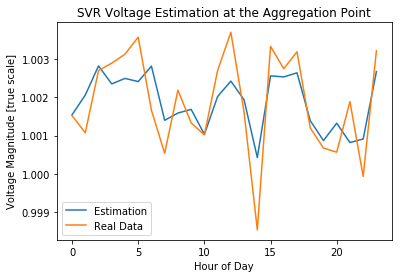

In [25]:
time_set = np.arange(0,24) # Look at the first day of the test set
which_bus_to_show = bus_try
plt.figure()
plt.plot(time_set,model.scale_back_sample_y(model.test_y_values_svr[time_set, 0], which_bus_to_show), time_set, model.scale_back_sample_y(model.y_test[time_set,which_bus_to_show], which_bus_to_show))
plt.xlabel('Hour of Day')
plt.ylabel('Voltage Magnitude [true scale]')
plt.title('SVR Voltage Estimation at the Aggregation Point')
plt.legend(labels=['Estimation','Real Data'])
plt.show()
# The corresponding error between the two is in model.test_error_values_svr[time_set]